In [1]:
import numpy as np

In [ ]:
###########################################################
#
# Gaussian Naive Bayes Classifier
#
############################################################
#
# Naive Bayes - P(Y | X) = P(X | Y) * P(Y) / P(X)
# Since P(X) is constant for all classes, we can ignore it for classification
# P(Y | X) -> P(X | Y) * P(Y)
#
# Gaussian assumption:
# P(X | Y) = product(P(x_i | Y), i=1 to n_features)
# where P(x_i | Y) ~ N(mu_y_i, sigma_y_i^2)
#
# Two variants implemented:
#
# 1. Likelihood-only GNB:
#     Ignores class priors P(Y)
#     Prediction: argmax_y P(X | Y)
#     Decision boundary independent of class imbalance
#     Answers: "Which class-specific Gaussian explains this point better?"
#
# 2. MAP GNB (Maximum A Posteriori):
#     Includes class priors P(Y)
#     Prediction: argmax_y P(X | Y) * P(Y)
#     Decision boundary shifts based on class frequencies
#     Answers: "Which class is more likely overall given this point?"
#
# Key difference:
#  Duplicating samples from one class shifts MAP boundary but not likelihood-only
# MAP incorporates dataset statistics, likelihood-only uses only distribution shapes

In [ ]:
#This cell contains more of thinking behind the model than clean abstractions.
import numpy as np

# DATASET
# (x1, x2) with binary labels
data = np.array([
    (1.0, 1.0), (1.2, 0.8), (0.8, 1.3), (1.1, 1.4),
    (3.0, 3.1), (2.8, 2.9), (3.2, 2.7), (3.1, 3.3)
])

y = [0, 0, 0, 0, 1, 1, 1, 1]

# number of features (x1, x2)
n_features = len(data[0])

# store mean and std for each feature and each class
# gauss_data_class[feature][class] = [mean, std]
gauss_data_class = [[[0.0, 0.0] for _ in range(2)] for _ in range(n_features)]

for i in range(n_features):
    # class 0
    vals_0 = [data[j][i] for j in range(len(data)) if y[j] == 0]
    gauss_data_class[i][0][0] = np.mean(vals_0)
    gauss_data_class[i][0][1] = np.std(vals_0)
    # class 1
    vals_1 = [data[j][i] for j in range(len(data)) if y[j] == 1]
    gauss_data_class[i][1][0] = np.mean(vals_1)
    gauss_data_class[i][1][1] = np.std(vals_1)

# unpack parameters (explicit on purpose)
mu_10, sigma_10 = gauss_data_class[0][0]
mu_20, sigma_20 = gauss_data_class[1][0]
mu_11, sigma_11 = gauss_data_class[0][1]
mu_21, sigma_21 = gauss_data_class[1][1]

def classifier(X):
    x1, x2 = X
    # log P(X | Y=0) + log P(Y=0)
    log_pred_0 = -0.5 * (((x1 - mu_10) / sigma_10) ** 2 + ((x2 - mu_20) / sigma_20) ** 2)
    # log P(X | Y=1) + log P(Y=1)
    log_pred_1 = -0.5 * (((x1 - mu_11) / sigma_11) ** 2 + ((x2 - mu_21) / sigma_21) ** 2)
    return 0 if log_pred_0 > log_pred_1 else 1

print("idx | x1   x2   | pred")
print("----+-----------+-----")
for i, x in enumerate(data):
    print(f"{i:>3} | {x[0]:4.1f} {x[1]:4.1f} |  {classifier(x)}")


idx | x1   x2   | pred
----+-----------+-----
  0 |  1.0  1.0 |  0
  1 |  1.2  0.8 |  0
  2 |  0.8  1.3 |  0
  3 |  1.1  1.4 |  0
  4 |  3.0  3.1 |  1
  5 |  2.8  2.9 |  1
  6 |  3.2  2.7 |  1
  7 |  3.1  3.3 |  1


In [ ]:
#A more cleaner implementation of the same model 
# dataset: 2D points with binary labels
X = np.array([[1.0, 1.0], [1.2, 0.8], [0.8, 1.3], [1.1, 1.4],
              [3.0, 3.1], [2.8, 2.9], [3.2, 2.7], [3.1, 3.3]])

y = np.array([0, 0, 0, 0, 1, 1, 1, 1])

# number of samples and features
n_samples, n_features = X.shape
classes = np.unique(y)

# estimate parameters for each class
# this is just MLE for mean and std assuming Gaussian noise
params = {}
for c in classes:
    X_c = X[y == c]
    means = np.mean(X_c, axis=0)
    stds = np.std(X_c, axis=0)
    params[c] = (means, stds)

# compute a score proportional to log P(x | Y=c)
# constants that cancel in argmax are dropped on purpose
def log_likelihood(x, means, stds):
    z = (x - means) / stds
    return -0.5 * np.sum(z**2)

# predict by comparing likelihood scores
# this ignores class priors on purpose
def predict(x):
    scores = {}
    for c in classes:
        means, stds = params[c]
        scores[c] = log_likelihood(x, means, stds)
    return max(scores, key=scores.get)


print("idx |   x1    x2  | true | pred")
print("----+-------------+------+-----")
for i, x in enumerate(X):
    print(f"{i:>3} | {x[0]:5.2f} {x[1]:5.2f} |  {y[i]}   |  {predict(x)}")


idx |   x1    x2  | true | pred
----+-------------+------+-----
  0 |  1.00  1.00 |  0   |  0
  1 |  1.20  0.80 |  0   |  0
  2 |  0.80  1.30 |  0   |  0
  3 |  1.10  1.40 |  0   |  0
  4 |  3.00  3.10 |  1   |  1
  5 |  2.80  2.90 |  1   |  1
  6 |  3.20  2.70 |  1   |  1
  7 |  3.10  3.30 |  1   |  1


In [ ]:
# MAP version of Gaussian Naive Bayes
# same model as before, but now we also include P(Y)
# so the score becomes: log P(X | Y=c) + log P(Y=c)

# estimate class priors from the data
# this is just relative frequency of each label
class_priors = {}
for c in classes:
    class_priors[c] = np.sum(y == c) / len(y)

# MAP prediction
# differs from likelihood-only only by the added log prior term
def predict_map(x):
    scores = {}
    for c in classes:
        means, stds = params[c]
        log_like = log_likelihood(x, means, stds)
        log_prior = np.log(class_priors[c])
        scores[c] = log_like + log_prior
    return max(scores, key=scores.get)

# check what changes compared to likelihood-only
print("idx | true | pred (MAP)")
print("----+------+-----------")
for i, x in enumerate(X):
    print(f"{i:>3} |  {y[i]}   |     {predict_map(x)}")


idx | true | pred (MAP)
----+------+-----------
  0 |  0   |     0
  1 |  0   |     0
  2 |  0   |     0
  3 |  0   |     0
  4 |  1   |     1
  5 |  1   |     1
  6 |  1   |     1
  7 |  1   |     1


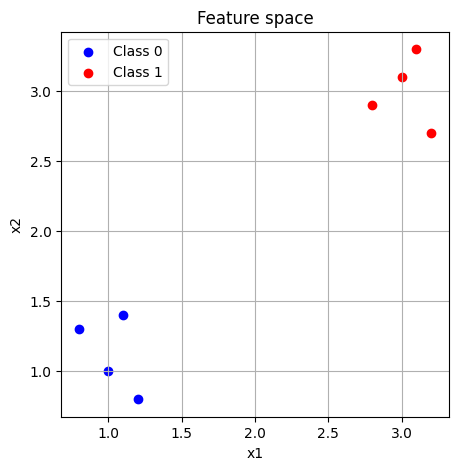

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X0 = X[y == 0]
X1 = X[y == 1]

plt.figure(figsize=(5, 5))
plt.scatter(X0[:,0], X0[:,1], c='blue', label='Class 0')
plt.scatter(X1[:,0], X1[:,1], c='red', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Feature space')
plt.grid(True)
plt.show()


 x1    x2  | Likelihood | MAP
-----------+------------+----
1.00 1.00 |     0      |  0
1.20 1.10 |     0      |  0
1.40 1.30 |     0      |  0
2.00 2.00 |     0      |  0
2.20 2.10 |     1      |  1
2.40 2.30 |     1      |  1
2.60 2.50 |     1      |  1
3.00 3.00 |     1      |  1
3.20 3.10 |     1      |  1


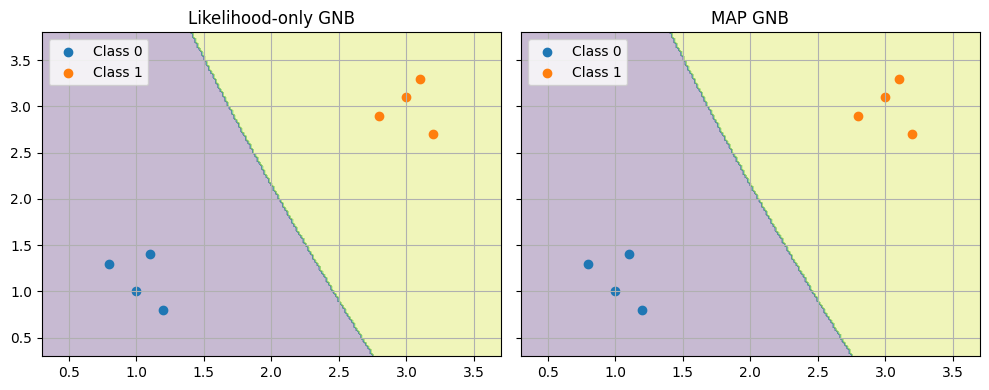

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test = np.array([[1.0, 1.0], [1.2, 1.1], [1.4, 1.3], [2.0, 2.0], [2.2, 2.1],
                   [2.4, 2.3], [2.6, 2.5], [3.0, 3.0], [3.2, 3.1]])

print(" x1    x2  | Likelihood | MAP")
print("-----------+------------+----")
for x in X_test:
    print(f"{x[0]:4.2f} {x[1]:4.2f} |     {predict(x)}      |  {predict_map(x)}")

# Decision surface
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))
grid = np.c_[xx1.ravel(), xx2.ravel()]

Z_like = np.array([predict(x) for x in grid]).reshape(xx1.shape)
Z_map = np.array([predict_map(x) for x in grid]).reshape(xx1.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Likelihood-only
axes[0].contourf(xx1, xx2, Z_like, alpha=0.3)
axes[0].scatter(X[y==0][:,0], X[y==0][:,1], label="Class 0")
axes[0].scatter(X[y==1][:,0], X[y==1][:,1], label="Class 1")
axes[0].set_title("Likelihood-only GNB")
axes[0].legend()
axes[0].grid(True)

#MAP
axes[1].contourf(xx1, xx2, Z_map, alpha=0.3)
axes[1].scatter(X[y==0][:,0], X[y==0][:,1], label="Class 0")
axes[1].scatter(X[y==1][:,0], X[y==1][:,1], label="Class 1")
axes[1].set_title("MAP GNB")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
